# Author: Nicolas Hernandez

## Forecasting Sticker Sales

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
print("Train set lenght:", len(train))

Train set lenght: 230130


In [4]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

The number of num_sold that is missing is really low commpared to the full lenght of the train dataset, so I will remove them without looking them much more.

In [5]:
train.dropna(inplace = True)

In [6]:
train['date'] = pd.to_datetime(train['date'])

Let's start with an simple data exploration

## Data Exploration

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [8]:
train["country"].value_counts()

country
Finland      38355
Italy        38355
Norway       38355
Singapore    38355
Canada       34109
Kenya        33730
Name: count, dtype: int64

In [9]:
train["store"].value_counts()

store
Premium Sticker Mart    75684
Stickers for Less       74044
Discount Stickers       71531
Name: count, dtype: int64

In [10]:
train["product"].value_counts()

product
Kaggle                46026
Kaggle Tiers          46026
Kerneler Dark Mode    46025
Kerneler              45962
Holographic Goose     37220
Name: count, dtype: int64

As a first resume:
* There are 6 countries in the dataset
* Only 3 stores are in the dataset
* There are 5 different products

All the option are almost equally distributed

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_sold', ylabel='Density'>

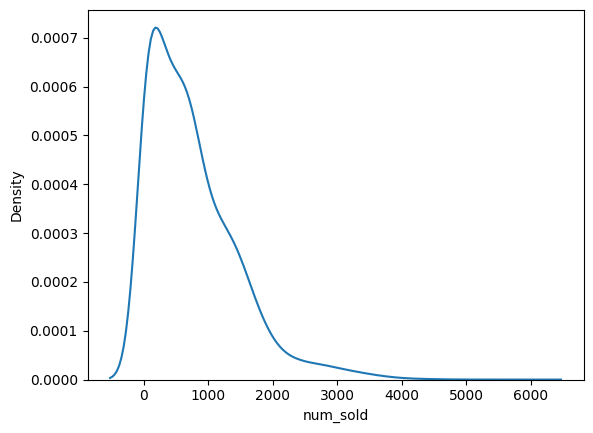

In [11]:
sns.kdeplot(data=train, x="num_sold", bw_adjust=3)

I decided to put the bw_adjust in a high value to see the density more smoother. With this plot is concluded that the target variable shows a positive skewness. If we want to obtain good results we should transform this data. But first let's group some of our categorical data and explore the mean tendency of some variables.

### Country

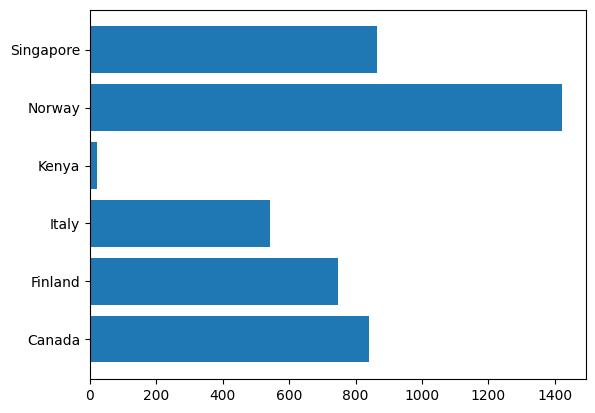

In [12]:
country = train.groupby(["country"])["num_sold"].mean().reset_index()
plt.figure()
plt.barh(country["country"], country["num_sold"])
plt.show()

<Axes: xlabel='country', ylabel='num_sold'>

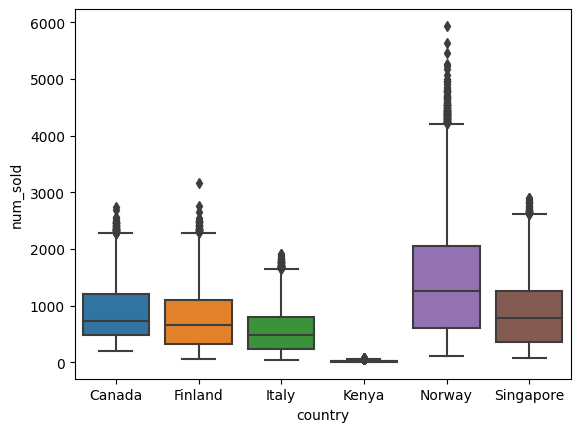

In [13]:
sns.boxplot(data=train, x="country", y="num_sold")

This plot olso shows that each country present a positive skewness. It also looks clear that Norway must have higher values of num_sold.

In [14]:
country_time = train.groupby(["date","country"])["num_sold"].mean().reset_index()
fig = px.line(country_time, x='date', y='num_sold', color='country',
              title="num_sold Over Time by Country")
fig.show()

We can observed some interesting things:
* Kenia shows an uptrend year after year
* A peak at the end/start of the year is clear for every country
* Singapour and Canada are very similar aver the time

### Store

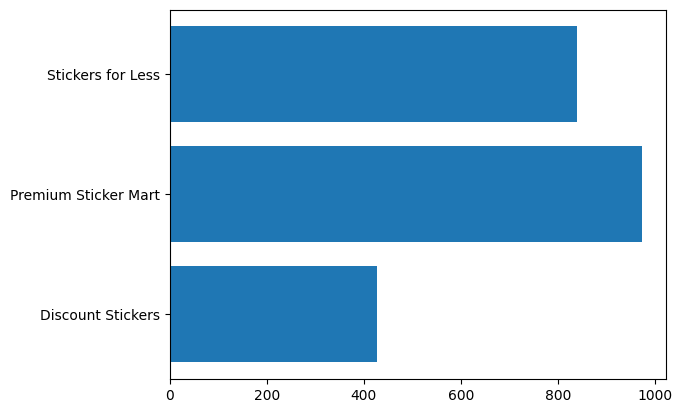

In [15]:
store = train.groupby(["store"])["num_sold"].mean().reset_index()
plt.figure()
plt.barh(store["store"], store["num_sold"])
plt.show()

<Axes: xlabel='store', ylabel='num_sold'>

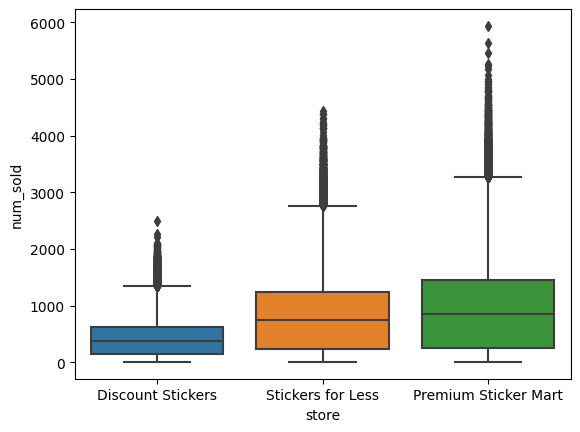

In [16]:
sns.boxplot(data=train, x="store", y="num_sold")

Store data continues to show the positive skewness. Also it is really clear that discount sticker is lower that the other stores options.

In [17]:
store_time = train.groupby(["date","store"])["num_sold"].mean().reset_index()
fig = px.line(store_time, x='date', y='num_sold', color='store',
              title="num_sold Over Time by Store")
fig.show()

The same trend over time with the peak at the start of the years is observed.

### Product

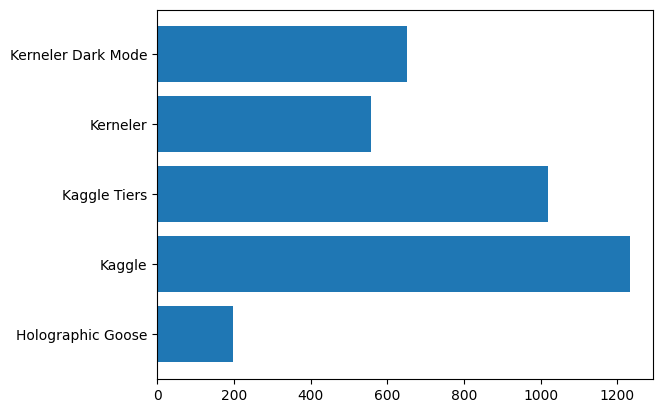

In [18]:
product = train.groupby(["product"])["num_sold"].mean().reset_index()
plt.figure()
plt.barh(product["product"], product["num_sold"])
plt.show()

We have kind of pairs. Two products (Kaggle and kaggle tiers) shows a higher mean than the other products. Then Kernelers products shows middle values of num_sold. Finally Holographic Goose is clearly the one realtic with low num_solds.

<Axes: xlabel='product', ylabel='num_sold'>

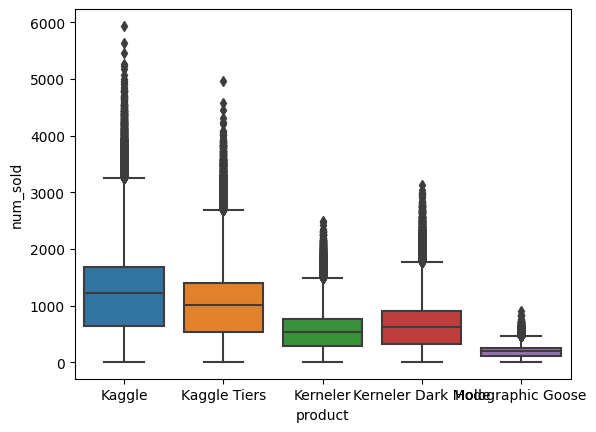

In [19]:
sns.boxplot(data=train, x="product", y="num_sold")

Products is the one feature in which the positive skewness is less visible. Nevertheless is still present.

In [20]:
product_time = train.groupby(["date","product"])["num_sold"].mean().reset_index()
fig = px.line(product_time, x='date', y='num_sold', color='product',
              title="num_sold Over Time by Product")
fig.show()

The trend between Kerneler and Kerneler dark mode is really interesting an fun. This should be interpreted with a sine and a cosine function. This example is the perfect reason on why the date should be taken into account.

### Feature engineer

I will started by transforming the num_sold in order to remove or disminish the positive skewness. Then i will create a new feature which is the year and i will transform the date using a sum of armonic functions.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='num_sold_log', ylabel='Density'>

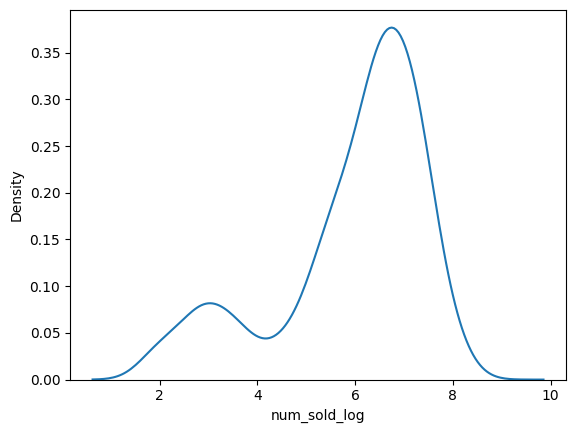

In [21]:
train['num_sold_log'] = np.log1p(train['num_sold'])
sns.kdeplot(data=train, x="num_sold_log", bw_adjust=3)

The logaritmic transformation result in a negative skewness, so we apply a different transformation.

Let's start with a square root transformation.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='num_sold_sqrt', ylabel='Density'>

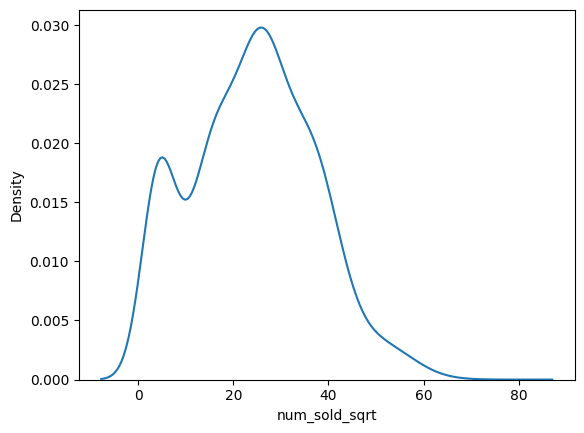

In [22]:
train['num_sold_sqrt'] = np.sqrt(train['num_sold'])
sns.kdeplot(data=train, x="num_sold_sqrt", bw_adjust=3)

Better but we shall explore other transformations. 

Let's follow with a cube root transformation.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='num_sold_cbrt', ylabel='Density'>

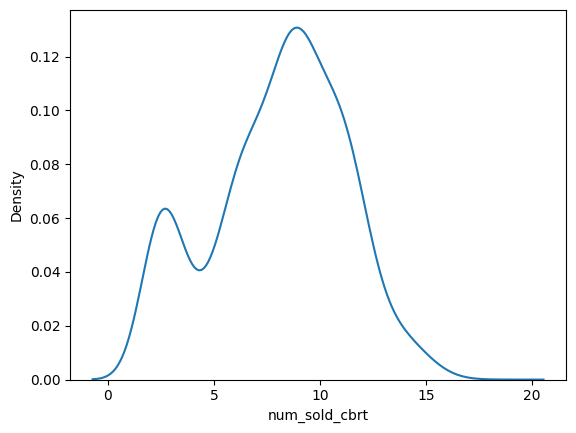

In [23]:
train['num_sold_cbrt'] = np.cbrt(train['num_sold'])
sns.kdeplot(data=train, x="num_sold_cbrt", bw_adjust=3)

Let's continue with a box cox transformation.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='num_sold_boxcox', ylabel='Density'>

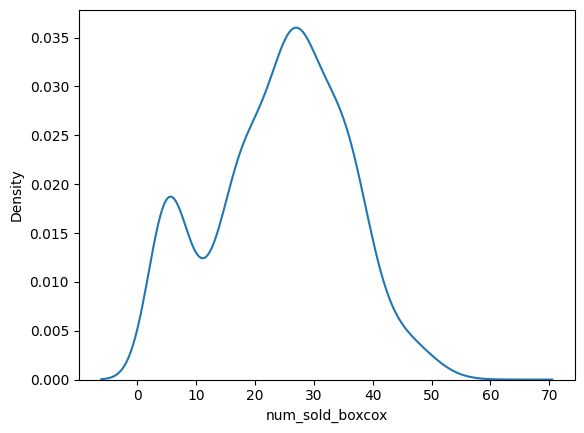

In [24]:
from scipy import stats
train['num_sold_boxcox'], lambda_ = stats.boxcox(train['num_sold'] + 1)  # +1 to avoid zero issues
sns.kdeplot(data=train, x="num_sold_boxcox", bw_adjust=3)

Until now the box cox is the one i like the most, as the ensity peak is higher. The square root is very close.

Let's finish with Yeo-Johnson Transformation.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='num_sold_yeojohnson', ylabel='Density'>

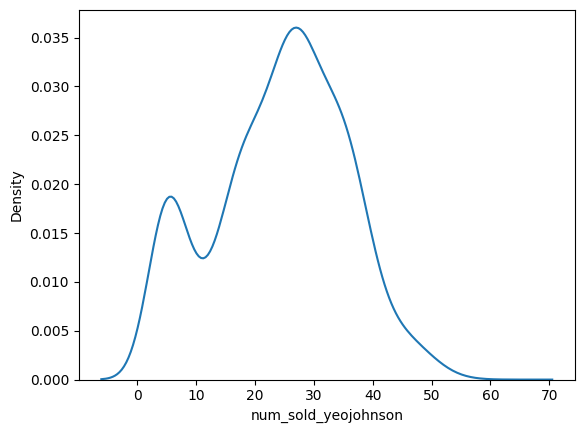

In [25]:
train['num_sold_yeojohnson'], lambda_yj = stats.yeojohnson(train['num_sold'])
sns.kdeplot(data=train, x="num_sold_yeojohnson", bw_adjust=3)

In [26]:
from scipy.stats import skew
skewness = {
    'Original': skew(train['num_sold']),
    'Log': skew(train['num_sold_log']),
    'Sqrt': skew(train['num_sold_sqrt']),
    'Cbrt': skew(train['num_sold_cbrt']),
    'Box-Cox': skew(train['num_sold_boxcox']),
    'Yeo-Johnson': skew(train['num_sold_yeojohnson'])
}
skewness_df = pd.DataFrame.from_dict(skewness, orient='index', columns=['Skewness'])
print(skewness_df.sort_values('Skewness'))

             Skewness
Log         -1.116369
Cbrt        -0.257392
Box-Cox     -0.168578
Yeo-Johnson -0.168578
Sqrt         0.177791
Original     1.415364


As interpreted from the plot, the ones that are close to a Gaussian distribution are the Box-Cox follow by the Square root. At first we will apply and sta with the box cox tranformation. The other columns will be drop.

**Note**: Yeo-Johnson is the same box-cox as the values are all positive.

In [27]:
train.drop(columns=['num_sold_log', 'num_sold_sqrt', 'num_sold_cbrt', 'num_sold_yeojohnson'], inplace = True)
train.head()

,id,date,country,store,product,num_sold,num_sold_boxcox
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,30.751907
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,29.895968
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,22.018590
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,23.393342
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,19.120697


In [28]:
from scipy.special import inv_boxcox
train['Original'] = inv_boxcox(train['num_sold_boxcox'], lambda_)-1
train.head()

,id,date,country,store,product,num_sold,num_sold_boxcox,Original
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,30.751907,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,29.895968,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,22.018590,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,23.393342,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,19.120697,300.0


Just checking that the inverse box-cox work properly. 

Now let's work with the date features

In [29]:
train['Year']= train['date'].dt.year
train['Month']= train['date'].dt.month
train['Day']= train['date'].dt.day
train['Month'] = np.cos(2*np.pi*train['Month']/12) + np.sin(2*np.pi*train['Month']/12)
train['Day'] = np.cos(2*np.pi*train['Day']/31) + np.sin(2*np.pi*train['Day']/31)
train.head()

,id,date,country,store,product,num_sold,num_sold_boxcox,Original,Year,Month,Day
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,30.751907,973.0,2010,1.366025,1.180828
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,29.895968,906.0,2010,1.366025,1.180828
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,22.018590,423.0,2010,1.366025,1.180828
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,23.393342,491.0,2010,1.366025,1.180828
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,19.120697,300.0,2010,1.366025,1.180828


Okay, let's start modeling

## Model

In this notebook I will explore the result for a catboost model as it handles categorical data very easily

In [30]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [31]:
data = train[["country", "store", "product", "Year", "Month", "Day", "num_sold_boxcox", "num_sold"]].copy()
X = data.drop(['num_sold_boxcox', 'num_sold'], axis=1)
y = data[['num_sold_boxcox', 'num_sold']].copy()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) #Separate train set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) #Create validation and test set

In [32]:
y_train_box = y_train['num_sold_boxcox']
y_val_box = y_val['num_sold_boxcox']
cat_features =["country", "store", "product"]
train_pool = Pool(data=X_train, label=y_train_box, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val_box, cat_features=cat_features)
model = CatBoostRegressor(
    learning_rate=0.1, 
    depth=6,
    verbose=10, 
    random_seed=42,
    loss_function = 'MAPE',
    early_stopping_rounds = 50
)
model.fit(train_pool, eval_set=val_pool, verbose=True)

0:	learn: 0.6308033	test: 0.6331189	best: 0.6331189 (0)	total: 137ms	remaining: 2m 16s
1:	learn: 0.5987572	test: 0.6011820	best: 0.6011820 (1)	total: 188ms	remaining: 1m 33s
2:	learn: 0.5723411	test: 0.5748727	best: 0.5748727 (2)	total: 256ms	remaining: 1m 25s
3:	learn: 0.5474840	test: 0.5501427	best: 0.5501427 (3)	total: 309ms	remaining: 1m 16s
4:	learn: 0.5266991	test: 0.5294220	best: 0.5294220 (4)	total: 358ms	remaining: 1m 11s
5:	learn: 0.5081278	test: 0.5109433	best: 0.5109433 (5)	total: 406ms	remaining: 1m 7s
6:	learn: 0.4924906	test: 0.4953355	best: 0.4953355 (6)	total: 461ms	remaining: 1m 5s
7:	learn: 0.4787159	test: 0.4815598	best: 0.4815598 (7)	total: 506ms	remaining: 1m 2s
8:	learn: 0.4664446	test: 0.4692928	best: 0.4692928 (8)	total: 559ms	remaining: 1m 1s
9:	learn: 0.4555692	test: 0.4584071	best: 0.4584071 (9)	total: 588ms	remaining: 58.3s
10:	learn: 0.4458378	test: 0.4486623	best: 0.4486623 (10)	total: 615ms	remaining: 55.3s
11:	learn: 0.4364894	test: 0.4392768	best: 0.43

In [33]:
y_pred = model.predict(X_train)
y_pred2 = inv_boxcox(y_pred, lambda_)-1
print(mean_absolute_percentage_error(y_train['num_sold'], y_pred2))

0.10397562107171984


In [34]:
y_pred = model.predict(X_val)
y_pred2 = inv_boxcox(y_pred, lambda_)-1
print(mean_absolute_percentage_error(y_val['num_sold'], y_pred2))

0.10385599492866607


In [35]:
y_pred = model.predict(X_test)
y_pred2 = inv_boxcox(y_pred, lambda_)-1
print(mean_absolute_percentage_error(y_test['num_sold'], y_pred2))

0.10504777921587732


Okay, the results look very promising.

In [36]:
train_pool = Pool(data=X, label=y['num_sold_boxcox'], cat_features=cat_features)
model.fit(train_pool, verbose=True)

0:	learn: 0.6323376	total: 101ms	remaining: 1m 40s
1:	learn: 0.6012019	total: 139ms	remaining: 1m 9s
2:	learn: 0.5721633	total: 196ms	remaining: 1m 5s
3:	learn: 0.5474075	total: 261ms	remaining: 1m 4s
4:	learn: 0.5267497	total: 337ms	remaining: 1m 7s
5:	learn: 0.5092144	total: 409ms	remaining: 1m 7s
6:	learn: 0.4936965	total: 494ms	remaining: 1m 10s
7:	learn: 0.4798939	total: 565ms	remaining: 1m 10s
8:	learn: 0.4676445	total: 648ms	remaining: 1m 11s
9:	learn: 0.4557003	total: 710ms	remaining: 1m 10s
10:	learn: 0.4448502	total: 760ms	remaining: 1m 8s
11:	learn: 0.4350651	total: 836ms	remaining: 1m 8s
12:	learn: 0.4269271	total: 878ms	remaining: 1m 6s
13:	learn: 0.4195275	total: 913ms	remaining: 1m 4s
14:	learn: 0.4121304	total: 977ms	remaining: 1m 4s
15:	learn: 0.3828508	total: 1.04s	remaining: 1m 4s
16:	learn: 0.3483436	total: 1.1s	remaining: 1m 3s
17:	learn: 0.3172284	total: 1.15s	remaining: 1m 2s
18:	learn: 0.2897223	total: 1.2s	remaining: 1m 1s
19:	learn: 0.2653751	total: 1.25s	rema

## Final Model

In [37]:
test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [38]:
test['date'] = pd.to_datetime(test['date'])
test['Year']= test['date'].dt.year
test['Month']= test['date'].dt.month
test['Day']= test['date'].dt.day
test['Month'] = np.cos(2*np.pi*test['Month']/12) + np.sin(2*np.pi*test['Month']/12)
test['Day'] = np.cos(2*np.pi*test['Day']/31) + np.sin(2*np.pi*test['Day']/31)
test.head()

,id,date,country,store,product,Year,Month,Day
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1.366025,1.180828
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1.366025,1.180828
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1.366025,1.180828
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1.366025,1.180828
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1.366025,1.180828


In [39]:
data_test = test[["country", "store", "product", "Year", "Month", "Day"]].copy()
test_pred = model.predict(data_test)
test["num_sold_boxcox"] = test_pred
test['num_sold'] = inv_boxcox(test['num_sold_boxcox'], lambda_)-1
test.head()

,id,date,country,store,product,Year,Month,Day,num_sold_boxcox,num_sold
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1.366025,1.180828,12.781435,116.290894
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1.366025,1.180828,26.093171,643.905242
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1.366025,1.180828,24.698166,561.614103
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1.366025,1.180828,18.643545,282.261814
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1.366025,1.180828,21.054034,379.070695


In [40]:
submission = test.filter(items={'id', 'num_sold'})

In [41]:
submission.to_csv("submission.csv", index=False)

In [42]:
submission

,num_sold,id
0,116.290894,230130
1,643.905242,230131
2,561.614103,230132
3,282.261814,230133
4,379.070695,230134
...,...,...
98545,300.644031,328675
98546,1889.136478,328676
98547,1610.048603,328677
98548,868.403570,328678
